<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/TCC_PUCMinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://anec.org.br/wp-content/uploads/2021/11/puc-minas-logo.jpg">

# Big Data in Space Science


* Import librarys
* Download data
* Preprocessing Datasets
* Bulding models
* Test Models
* Compare results


# 1. Introdução

## Check Version

Um problema da reprodutibilidade de experimentos computacionais esta na dinamicidade de versões de bibliotecas e funções que possuem módulos que são atualizados e decreipitados. Esse experimento foi desenvolvido entre 2022 e 2023. Para isso utilizamos as versões abaixos to python, keras, tensorflow:

In [39]:
!python --version

Python 3.9.16


## Bibliotecas

In [40]:
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
#Importing Librarys 📚
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
#import math
import seaborn as sns
import pandas as pd
#import time # for time mesurment
import random
from matplotlib.pyplot import figure


from sklearn.model_selection import  GridSearchCV ,RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import pickle

#from xgboost import XGBClassifier
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.layers import Dropout, Activation, Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from IPython.display import HTML

import optuna
import pickle

seed = 55
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)

2.12.0


Para garantir a reprodutibilidade deste experimento é importante que as bibliotecas estejam todas na mesma versão o código a baixo deve produzir o seguinte output. Caso contrário instale as versões corretamente

```
numpy 1.20.1
keras 2.9.0
TensorFlow 2.9.0
sklearn 0.24.1
optuna 3.0.3
seaborn 0.11.1
pandas 1.4.3
matplotlib 3.5.2
```

In [42]:
print('numpy',np.__version__)
print('keras',keras.__version__)
print('TensorFlow',tf.keras.__version__)
print('sklearn',sklearn.__version__)
print('optuna',optuna.__version__)
print('seaborn',sns.__version__)
print('pandas',pd.__version__)
print('matplotlib',matplotlib.__version__)


numpy 1.22.4
keras 2.12.0
TensorFlow 2.12.0
sklearn 1.2.2
optuna 3.1.1
seaborn 0.12.2
pandas 1.4.4
matplotlib 3.7.1


# 2. Coleta de Dados
https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

In [ ]:
#Se tiver rodando esse código no google colab descomente as linhas abaixo
#Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')
#Importando e configurando o Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessando o diretório do Kaggle
%cd /content/drive/MyDrive/Kaggle/
# Fazendo o dowload do NASA data-set
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
#Unziping data-set
!unzip "nasa-nearest-earth-objects.zip" -d "/content/"
# Fazendo o dowload do NASA data-set
!kaggle datasets download -d basu369victor/prediction-of-asteroid-diameter

!unzip "prediction-of-asteroid-diameter.zip" -d "/content/"

In [ ]:
#Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

### Setando parâmetros


In [44]:
# Gerando uma lista de 10 cores do mapa de cores "Spectral" no formato de ponto flutuante
colors = sns.color_palette("Spectral", n_colors=10, as_cmap=False)
# Convertendo as cores de ponto flutuante para RGB
colors_rgb = [(int(r * 255), int(g * 255), int(b * 255)) for (r, g, b) in colors]
def rbg_to_hex(color): return "#{:02x}{:02x}{:02x}".format(*color)
div_colors = [rbg_to_hex(colors_rgb[-1]),rbg_to_hex(colors_rgb[0])]

### Funções

In [45]:
def plot_cmatrix(y_test, y_pred, title='Matriz de correlação',vmin=0,vmax=None,color='Blues'):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, cmap=color, fmt='g', xticklabels=['Verdadeiro', 'Falso'], yticklabels=['Verdadeiro', 'Falso'],vmin=vmin, vmax=vmax)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'{title}\nAcc - {round(metrics.accuracy_score(y_test,y_pred)*100,3)}%')
     

# Nasa-nearest-earth-objects

## 3.1 Processamento/Tratamento de Dados

In [46]:
#Lendo os dados
ds1= "Nasa Nearest Earth Objects"
df_nasa = pd.read_csv('neo.csv')
df_nasa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Primeiro observaremos a correlação entre todo os dados do nosso dataframe

<Axes: title={'center': 'Correlação completa entre as variáveis para o dataset "Nasa Nearest Earth Objects"'}>

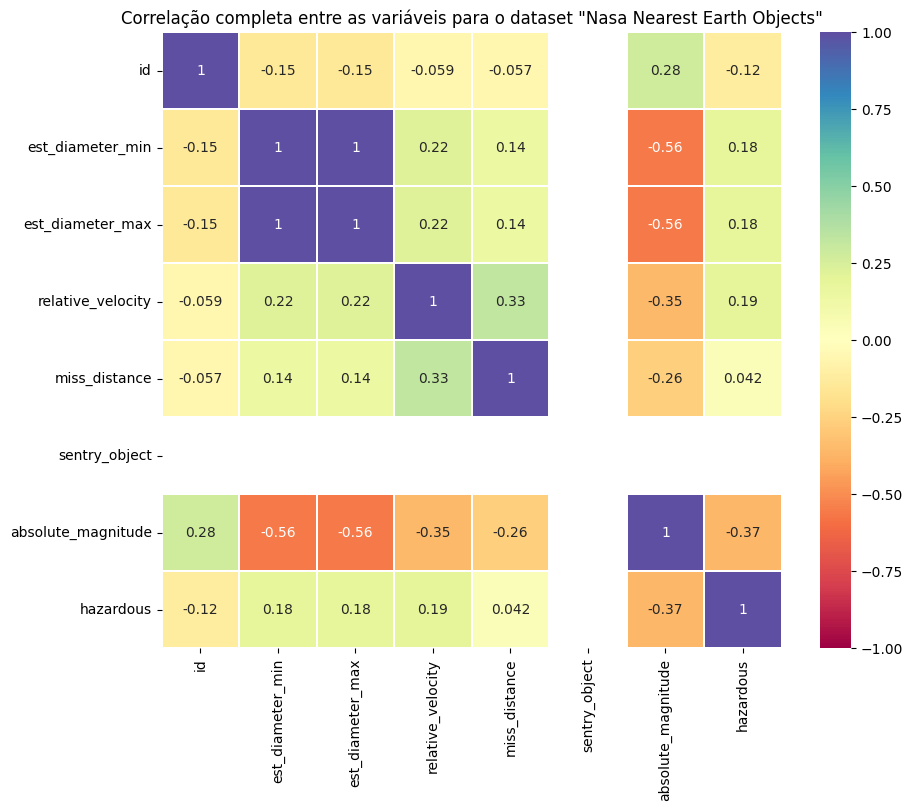

In [47]:
plt.figure(figsize=(10,8),dpi=100)
df_nasa = pd.read_csv('neo.csv')
plt.title(f'Correlação completa entre as variáveis para o dataset "{ds1}"')
sns.heatmap(df_nasa.corr(),
            annot=True, 
            linewidths = 0.1, 
            linecolor = 'white', 
            cmap="Spectral",
            vmin=-1, 
            vmax=1)

Naturalmente alguns dados não possuem interesse físico para a nossa analise dados. Dessa forma iremos definir um novo conjunto de dados que é um recorte dos dados gerais. Chamaremos esse recorte de `features`

In [48]:
features = df_nasa.drop(['id', 'name', 'orbiting_body','est_diameter_max',
                         'sentry_object'], axis=1)

<Axes: title={'center': 'Correlação das Features que são utilizadas no dataset "Nasa Nearest Earth Objects"'}>

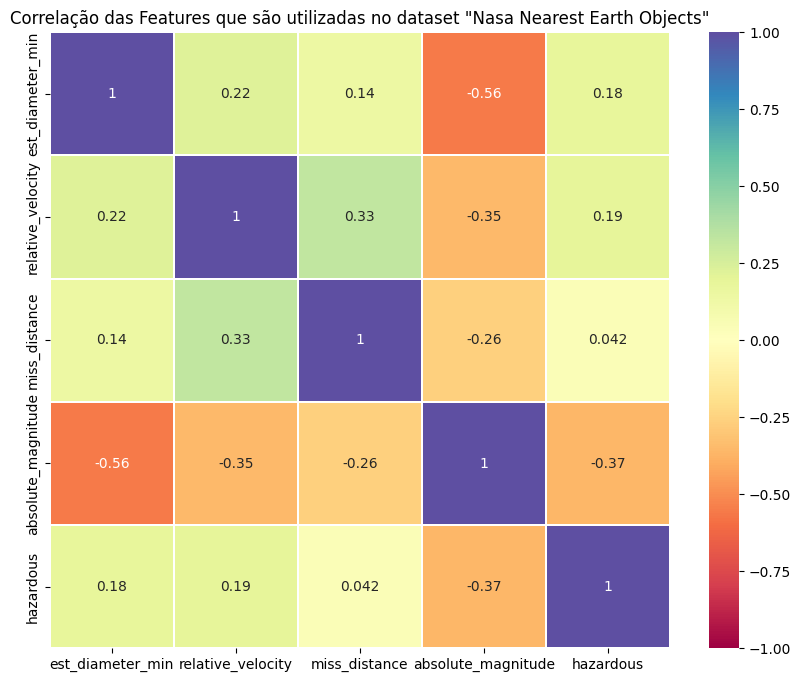

In [49]:
plt.figure(figsize=(10,8))
plt.title(f'Correlação das Features que são utilizadas no dataset "{ds1}"')
sns.heatmap(features.astype(float).corr(),
            annot=True, 
            linewidths = 0.1, 
            linecolor = 'white', 
            cmap="Spectral",
            vmin=-1, 
            vmax=1)

In [50]:
#Print uma resumo estatístico do dataset
features.describe()

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,48066.918918,3.706655e+07,23.527103
std,0.298511,25293.296961,2.235204e+07,2.894086
min,0.000609,203.346433,6.745533e+03,9.230000
25%,0.019256,28619.020645,1.721082e+07,21.340000
50%,0.048368,44190.117890,3.784658e+07,23.700000
75%,0.143402,62923.604633,5.654900e+07,25.700000
max,37.892650,236990.128088,7.479865e+07,33.200000


## 4.1 Análise e Exploração dos Dados

Não há uma ordem de grandeza específica de dados que determine se o uso de `kernel_regularizer` nas camadas intermediárias é necessário ou não. Em vez disso, é importante avaliar a complexidade da rede neural, a quantidade de dados disponíveis e a natureza do problema específico para decidir se a regularização é necessária e em que grau ela deve ser aplicada.

Em geral, quanto mais complexa for a rede neural, com muitas camadas e um grande número de parâmetros, maior será a probabilidade de ocorrer overfitting e, portanto, maior será a necessidade de regularização. Além disso, se a quantidade de dados disponíveis for relativamente pequena em comparação com a complexidade do modelo, a regularização pode ser necessária para evitar o overfitting.

O grau de regularização necessário depende do problema específico e do conjunto de dados em questão. Se o modelo estiver apresentando overfitting, pode ser necessário aumentar a intensidade da regularização. Por outro lado, se o modelo estiver apresentando underfitting, pode ser necessário reduzir a intensidade da regularização.

Em resumo, não existe uma regra universal para determinar se e em que grau deve ser aplicado o kernel_regularizer nas camadas intermediárias de uma rede neural. É importante avaliar cuidadosamente a complexidade da rede, a quantidade de dados disponíveis e o desempenho do modelo para decidir se a regularização é necessária e em que grau ela deve ser aplicada.

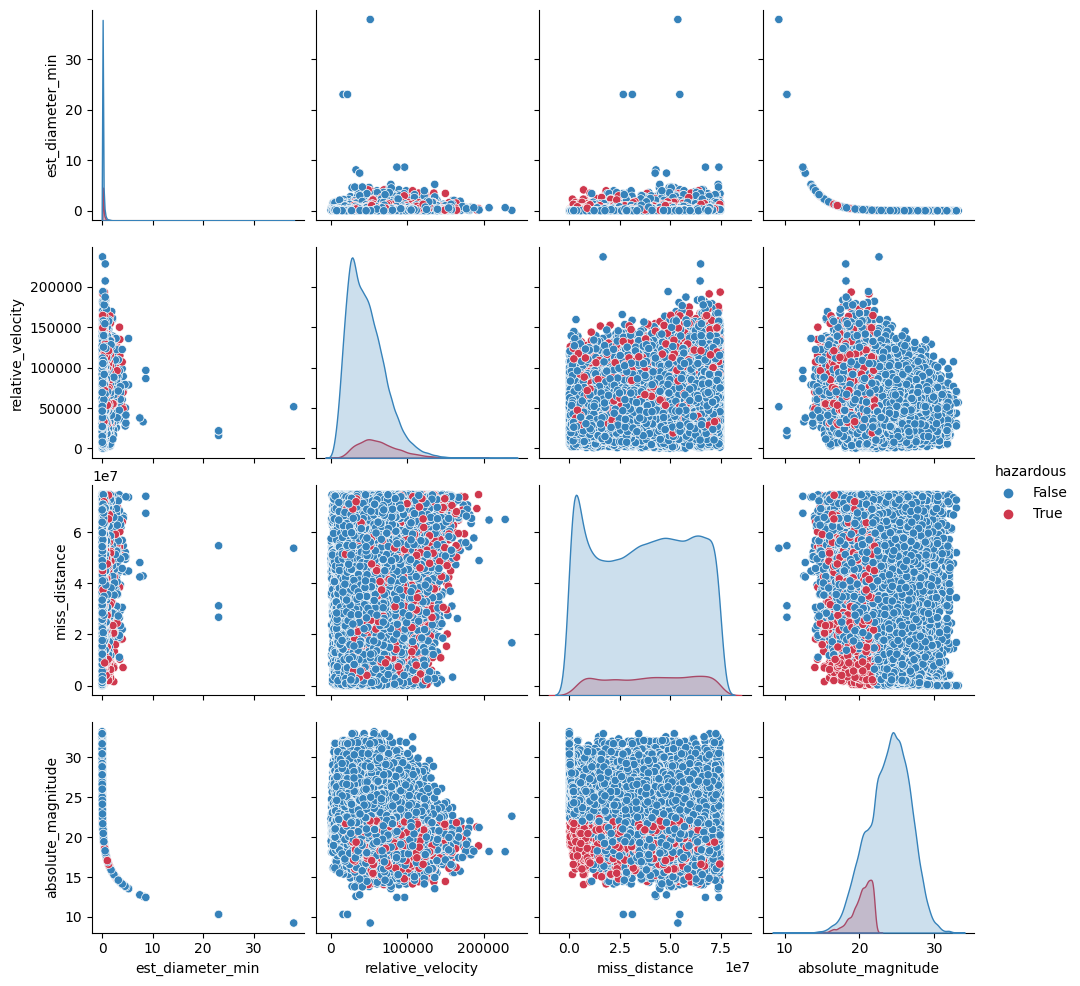

In [51]:
sns.pairplot(features,hue='hazardous',palette=div_colors)#,corner=True)

Nesse momento podemos observar pela análise de dados que que `est_diameter_max` possui uma alta correlação com dados fazendo dele uma feature não interessante para o nosso problema. Assim iremos retirá-lo do nosso experimento

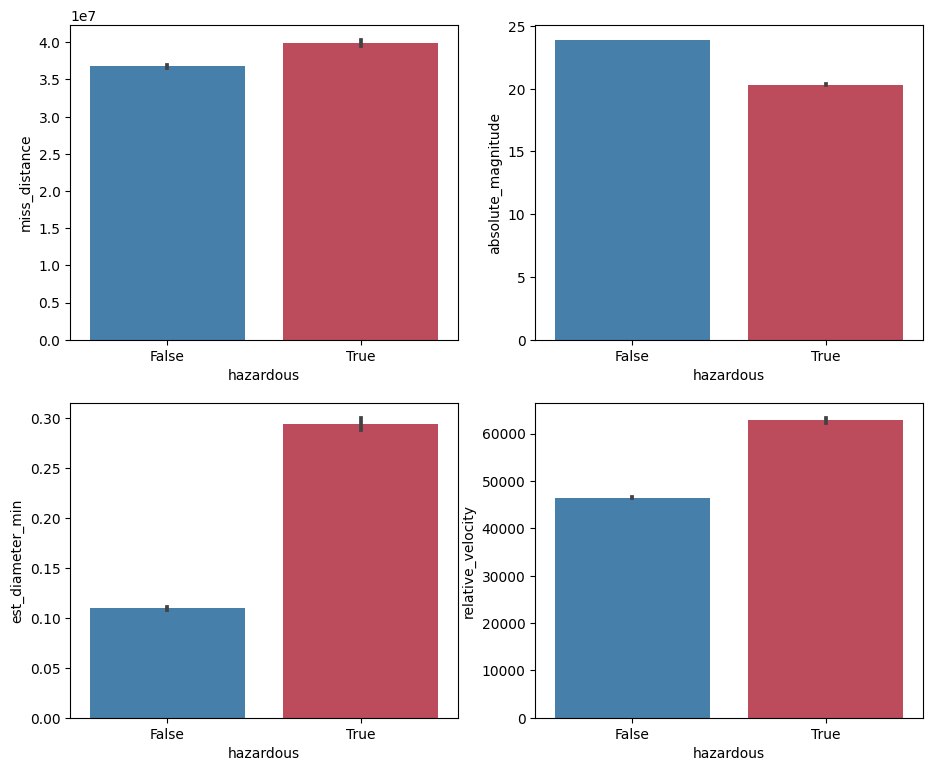

In [52]:
colunas = ['miss_distance','absolute_magnitude', 'est_diameter_min', 'relative_velocity']
plt.figure(figsize=(11,9),dpi=100)
b=1
for i in colunas:
    plt.subplot(2,2,b)
    sns.barplot(data=features,x='hazardous',y=i,palette=div_colors)
    b+=1


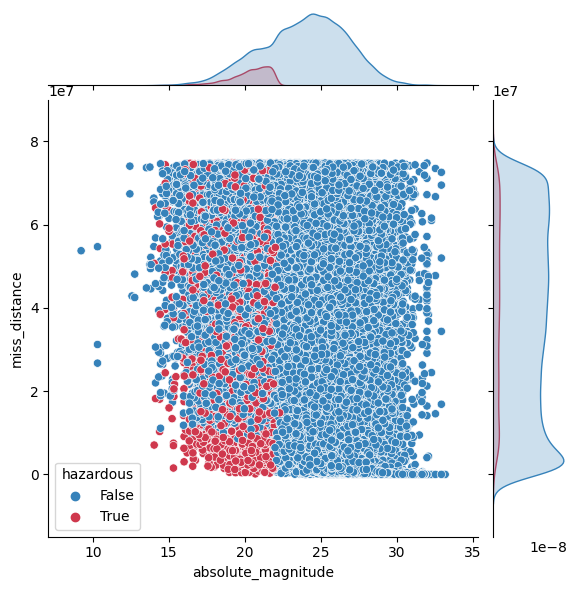

In [53]:
sns.jointplot(data=features,x='absolute_magnitude',y='miss_distance',hue='hazardous',palette=div_colors)

In [ ]:
plt.figure(figsize=(12,8),dpi=100)
colunas = ['miss_distance','absolute_magnitude', 'est_diameter_min', 'relative_velocity']
# plt.figure(figsize=(11,9),dpi=100)
b=1
for i in colunas:
    plt.subplot(2,2,b)
    # sns.barplot(data=features,x='hazardous',y=i,palette=div_colors)
    sns.histplot(data=features,x=i,kde=True,hue='hazardous',palette=div_colors)
    b+=1



## 5.1 Criação de Modelos de Machine Learning

### 5.1.1 Pré Processamento

In [ ]:
df = features
scaler =StandardScaler() #instantiate
scaler.fit(df[['est_diameter_min', 'relative_velocity', 'miss_distance','absolute_magnitude']]) #fit
scaled = scaler.transform(df[['est_diameter_min', 'relative_velocity', 'miss_distance','absolute_magnitude']]) #transform
scaled_df = pd.DataFrame(scaled) #convert to dataframe
X = scaled_df
Y = df['hazardous']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=55)

In [ ]:
plt.figure(figsize=(10, 5),dpi=100)
plt.suptitle("Distribuição dos dados de treino e teste", y=0.99)
plt.subplot(1, 2, 1)
plt.title("y_train")
plt.bar(y_train.value_counts().index, y_train.value_counts().values,color=div_colors)

plt.subplot(1, 2, 2)
plt.title("y_test")
plt.bar(y_test.value_counts().index, y_test.value_counts().values,color=div_colors)


In [ ]:
plt.figure(figsize=(10, 5),dpi=100)
plt.suptitle(f"Distribuição dos dados de treino e teste em pizza para o dataset '{ds1}'", y=0.99)
plt.subplot(1, 2, 1)
plt.title("y_train")
plt.pie((y_train.value_counts()).values, labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=90, colors=div_colors)
plt.subplot(1, 2, 2)
plt.title("y_test")
plt.pie((y_test.value_counts()).values, labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=90, colors=div_colors)
plt.show()

### 5.2.1 Machine Learning

#### Floresta Aleatória

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)#, max_depth=50, random_state=55)
rfc.fit(x_train,y_train)
pred_rfc = rfc.predict(x_test)
#plot_cmatrix(y_test,pred_rfc,title='Floresta Aleatória')

In [ ]:
# #Floresta Aleatória com exploração de hiperparâmetros

# #rfc = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=55)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=55)
# param_grid = {
#     'n_estimators': [50, 100,200],
#     'max_depth': [None, 5, 10]}#,
#     #'min_samples_split': [2, 5, 10],
#     #'min_samples_leaf': [1, 2, 4]
# #}
# rfc = GridSearchCV(rfc, param_grid=param_grid, cv=5)
# #rfc.fit(x_train, y_train)
# #print("Best parameters: ", grid_search.best_params_)
# #print("Best score: ", grid_search.best_score_)
# rfc.fit(x_train,y_train)
# pred_rfc = rfc.predict(x_test)
# #pred_rfc = rfc.best_estimator_.predict_proba(x_test)[:,1]
# plot_cmatrix(y_test,pred_rfc,title='Floresta Aleatória')

#### Regressão Logistica

In [ ]:
logreg = LogisticRegression(n_jobs=-1, random_state=55)
logreg.fit(x_train,y_train)
pred_logreg = logreg.predict(x_test)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(y_test,pred_logreg,title='Regressão Logística')

In [ ]:
# #Explorando diferentes hiperparâmetros para o LogisticRegression
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga']
# }
# grid_search = GridSearchCV(logreg, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)
# # >>> Best parameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
# # >>> Best score:  0.9030746245183613

# pred_logreg = grid_search.predict(x_test)
# plot_cmatrix(y_test,pred_logreg,title='Regressão Logística')

#### K-Means

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
knn.fit(x_train,y_train)
pred_knn = knn.predict(x_test)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(y_test,pred_knn,title='KNN')

In [ ]:
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9,11,13,15],
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['ball_tree', 'kd_tree', 'brute']
# }
# grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)
# pred_knn = grid_search.predict(x_test)
# #print("Knn Accuracy score =", metrics.accuracy_score(y_test,pred_knn))
# plot_cmatrix(y_test,pred_knn,title='KNN')

#### Naive Bayes

In [ ]:
nb = GaussianNB(n_jobs=-1,random_state=55)
nb.fit(x_train,y_train)
pred_naiveb = nb.predict(x_test)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(y_test,pred_naiveb,title='Naive Bayes')


In [ ]:
# #Explorando diferentes hiperparâmetros para o GaussianNB
# nb = GaussianNB()
# param_grid = {
#     'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
# }
# grid_search = GridSearchCV(nb, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

#### Gradient Boosting



In [ ]:
gb=GradientBoostingClassifier(n_jobs=-1,random_state=55)
gb.fit(x_train,y_train)
pred_gb=gb.predict(x_test)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(y_test,pred_gb,title='Gradient Boosting')

In [ ]:
# #Explorando diferentes hiperparâmetros para o GradientBoostingClassifier
# gb = GradientBoostingClassifier()
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(gb, param_grid=param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

### 5.2.2 Deep Learning

#### MLP

In [ ]:
#Defining the feature how will be our classify 🎯
targets = features['hazardous']
features = features.drop('hazardous', axis=1)
targets.value_counts()

In [ ]:
#Normalize data
scaler = MinMaxScaler() 
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
#features.head()

In [ ]:
## Split in Traing and Test
x_train, x_test, y_train, y_test = train_test_split(features, targets, random_state=55, test_size=0.3)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

#### Rede Simples

In [ ]:
# Model definition
regul = 0.1
dropo = 0.2
moment= 0.1

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment)
model = (Sequential())
model.add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul),activation='relu'))
model.add(Dropout(dropo))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x_train.values, y_train.values, epochs=20, batch_size=32,
                        validation_data=(x_test.values,  y_test.values), verbose=1, shuffle=True)

pred_mlp = np.round(model.predict(x_test.values))
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(y_test.values,pred_mlp)    

#### Pesquisa por Grade

In [ ]:
# # Model definition
# #x_train, x_test, y_train, y_test
# #i = 0
# regul = [0.0,0.2,0.0,0.0,0.2,0.2]
# dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
# moment= [0.0,0.0,0.0,0.2,0.2,0.2]
# model_NASA_1 = []
# for i in range(len(regul)):
#   sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
#   model_NASA_1.append(Sequential())
#   model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
#   model_NASA_1[i].add(Dropout(dropo[i]))
#   model_NASA_1[i].add(Dense(1, activation='sigmoid'))
#   model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# #model.summary()

#### Utilizando o Otuna

In [ ]:

# def objective(trial):
#     epochs       = 2
#     neuron_min   = 10
#     neuron_max   = 512
#     min_layer    = 1
#     max_layer    = 10
#     # lr_mim       = 1e-4
#     # lr_max       = 5e-1
#     drop_max     = 0.3
#     drop_min     = 0.0
#     # momentum_max = 0.3
#     # momentum_min = 0.0
#     regul_max    = 0.3
#     regul_min    = 0.0

#     n_layers       = trial.suggest_int('n_layers', min_layer, max_layer)
#     #lr             = trial.suggest_float('lr', lr_mim, lr_max)
#     optimizer      = trial.suggest_categorical('optimiser',['SGD','Adam'])
#     neurons   =[]
#     activations   =[]
#     dropouts   =[]
#     regul = []
#     for i in range(max_layer+1):
#             neurons.append(trial.suggest_int(f'neurons{i+1}', neuron_min, neuron_max))
#             activations.append(trial.suggest_categorical(f'activations{i+1}',["sigmoid", "relu", "tanh"]))
#             dropouts.append(trial.suggest_float(f'dropouts{i+1}', drop_min, drop_max))
#             regul.append(trial.suggest_float(f'regul{i+1}', regul_min, regul_max))
# #Modelo
#     model = Sequential()
#     model.add(Dense(neurons[0], input_dim=x_train.shape[1], kernel_regularizer=l2(regul[0]),activation=activations[0]))
#     model.add(Dropout(dropouts[0]))
#     #Camadas ocultas
#     for i in range(n_layers):
#         model.add(Dense(neurons[i+1], kernel_regularizer=l2(regul[i+1]),activation=activations[i+1]))
#         model.add(Dropout(dropouts[i+1]))
#     #Camada de saída
#     model.add(Dense(1, activation=activations[n_layers+1]))
#     #Compilando o modelo
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

#     #model.summary()
#     history = model.fit(x_train.values, y_train.values, epochs=epochs, batch_size=32,
#                         validation_data=(x_test.values,  y_test.values), verbose=1, shuffle=True)
#     loss, accuracy = model.evaluate(x_test, y_test)
#     model.save(f'save_models/model{trial.number}.h5')
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=2)

# best_trial = study.best_trial
# with open('best_trial.pkl', 'wb') as f:
#     pickle.dump(best_trial, f)


In [ ]:
# Lendo o valor com o melhor resultado
with open('best_trial.pkl', 'rb') as f:
    best_trial = pickle.load(f)

print('Best trial:')
print(f'  Value: {best_trial.value}')
print('  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# # Model definition
# #x_train, x_test, y_train, y_test
# #i = 0
# regul = [0.0,0.2,0.0,0.0,0.2,0.2]
# dropo = [0.0,0.0,0.2,0.0,0.0,0.2]
# moment= [0.0,0.0,0.0,0.2,0.2,0.2]
# model_NASA_1 = []
# for i in range(len(regul)):
#   sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment[i])
#   model_NASA_1.append(Sequential())
#   model_NASA_1[i].add(Dense(5, input_dim=x_train.shape[1], kernel_regularizer=l2(regul[i]),activation='relu'))
#   model_NASA_1[i].add(Dropout(dropo[i]))
#   model_NASA_1[i].add(Dense(1, activation='sigmoid'))
#   model_NASA_1[i].compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# #model.summary()

#### Plotando os reultados

In [ ]:
plt.figure(figsize=(12,6),dpi=100)
plt.suptitle(f'Matriz de confusão para todos os modelos no dataset "{ds1}"',y=1.0)
preds = [pred_logreg,pred_knn,pred_naiveb,pred_gb,pred_rfc,pred_mlp]
titles = ['Regressão Logística','KNN','Naive Bayes','Gradient Boosting','Floresta Aleatória','MLP']
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for i in range(len(preds)):
    plt.subplot(2,3,i+1)
    plot_cmatrix(y_test.values,preds[i],title=titles[i],color='Spectral',vmax=2500,vmin=0)     
    

In [ ]:
#Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(10,4),dpi=100)
plt.suptitle(f' Acurácia e Loss da MLP\nno dataset "{ds1}"',y=1.05)
plt.subplot(1,2,2)
#Horitontal space between subplots
plt.subplots_adjust(wspace=0.3)
plt.plot(history.history['loss'], color='C0', label="Treino")
plt.plot(history.history['val_loss'], color='C1', label="Validação",axes =plt.gca())
plt.ylabel('Score')
plt.xlabel('Época')
plt.legend(loc='best', shadow=True)
plt.title("Loss")

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='C0', label="Treino")
plt.plot(history.history['val_accuracy'], color='C1',label="Validação")
plt.legend(loc='best', shadow=True)
plt.ylabel('Score')
plt.xlabel('Época')
plt.title("Acurácia")
plt.show()

In [ ]:

#pred_mlp = model.predict(x_test.values)
pred_mlp = np.round(model.predict(x_test.values))
plot_cmatrix(y_test.values,pred_mlp)

In [ ]:


i = 1
#Confusion Matrix
N_rows, N_colluns = 6,2

#figure(figsize=(18,20),dpi=80)
plt.suptitle('Topology NASA 1')
for i in range(0,1):
  figure(figsize=(18,20),dpi=80)
  plt.subplot(N_rows,N_colluns,((2*i+1)))
  plt.title('Training = L2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums)+'')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_train.values, np.round(model.predict(x_train.values))),index=('Positive', 'Negative'),columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  

  plt.subplot(N_rows,N_colluns,((2*i+2)))
  plt.title('Test = L2 '+str(regul)+' - Drop  '+str(dropouts)+' - Momen '+str(momentums))
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test.values, np.round(model.predict(x_test.values))),
                                  index=('Positive', 'Negative'), 
                                  columns=('Positive', 'Negative'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Blues",  vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')#, fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')#, fontsize=14)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Prediction-of-asteroid-diameter

https://www.kaggle.com/datasets/basu369victor/prediction-of-asteroid-diameter/code

https://www.kaggle.com/datasets/brsdincer/asteroid-classification-for-hazardous-prediction/code

## 3.2 Processamento/Tratamento de Dados

In [ ]:
from sklearn.preprocessing import scale ,LabelEncoder, scale,  StandardScaler
from scipy.stats import levene, shapiro
from scipy.stats.stats import pearsonr 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from skompiler import skompile
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [ ]:
#Lendo os dados
ds2 = 'Prediction of Asteroid Diameter'
df_asteoid = pd.read_csv('Asteroid_Updated.csv')
df_asteoid.info()


In [ ]:
# Plotando a Matrix de correlação COMPLETA para os dados
plt.figure(figsize=(20,16),dpi=100)
plt.title(f'Correlação completa entre as variáveis para o dataset "{ds2}"')
sns.heatmap(df_asteoid.corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral",vmin=-1, vmax=1)
plt.show()

In [ ]:
# Retirando as colunas que não serão utilizadas 
df_asteoids = df_asteoid.drop(["name", "condition_code",
                          "extent", "IR", "diameter", "data_arc", "n_obs_used",
                          "spec_B", "spec_T", "class",
                          "rot_per", "GM", "BV", "UB", "G", "albedo","per_y",'ad'], axis=1)
data = df_asteoids.copy() #criando uma cópia do dataset

encode = LabelEncoder() #transformando as variáveis categóricas em numéricas
data["pha"] = encode.fit_transform(data["pha"]) #transformando a variável pha em numérica
data["neo"] = encode.fit_transform(data["pha"]) #transformando a variável neo em numérica
dfCorr = data.select_dtypes(include=["float64", "int64", "int32"]) #selecionando as variáveis numéricas

data.dropna(how="all", inplace=True) # retirando as linhas que estão completamente vazias
listColumnsNumeric = ["a", "n", "per", "ma", "H"] #selecionando as variáveis numéricas
for i in listColumnsNumeric:
    data[i].fillna(data[i].mean(), inplace=True) #preencheno os valores faltantes com a média
data.dropna(inplace=True) #retirando as linhas que ainda estão com valores faltantes

In [ ]:
# Plotando a Matrix de correlação para os dados tratados
plt.figure(figsize=(20,16),dpi=100)
plt.title(f'Correlação entre as variáveis para o dataset "{ds2}" ja processado')
sns.heatmap(data.corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral",vmin=-1, vmax=1)
plt.show()

In [ ]:
data.describe() #descrevendo o dataset

## 4.2 Análise e Exploração dos Dados

In [ ]:
colunas = ['a', 'e', 'i', 'om', 'w', 'q', 'H', 'neo',  'moid',
       'n', 'per', 'ma']
plt.figure(figsize=(16,10),dpi=100)
b=1
for i in colunas:
    plt.subplot(4,4,b)
    #plt.ylabel(i)
    sns.barplot(data=data,x='pha',y=i,palette=div_colors)
    plt.subplots_adjust(hspace=0.3,wspace=0.4)
    b+=1


In [ ]:
plt.figure(figsize=(12,8),dpi=100)
#plt.subplot(2,2,1)
sns.histplot(data=data,x='q',kde=True,hue='pha',palette=div_colors)


## 5.2 Criação de Modelos de Machine Learning

### 5.2.1 Pré Processamento

In [ ]:
x = data#.drop(["pha",'per_y','ad'], axis=1)
scaler =StandardScaler()
scaler.fit(x)
scaled = scaler.transform(x)
scaled_df2 = pd.DataFrame(scaled, columns=x.columns)
x = scaled_df2
y = data["pha"].astype(bool) #Convertendo para dado boleando 

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=55)

In [ ]:
plt.figure(figsize=(20,16),dpi=100)
plt.title(f'Correlação entre as variáveis para o dataset "{ds2}" usadas no treinamento')
sns.heatmap(x.corr(),annot=True, linewidths = 0.1, linecolor = 'white', cmap="Spectral",vmin=-1, vmax=1)

In [ ]:
plt.figure(figsize=(10, 5),dpi=100)
plt.suptitle(f"Distribuição dos dados de treino e teste para o data set {ds2}", y=0.99)
plt.subplot(1, 2, 1)
plt.title("yTrain")
plt.bar(yTrain.value_counts().index, yTrain.value_counts().values,color=div_colors)

plt.subplot(1, 2, 2)
plt.title("yTest")
plt.bar(yTest.value_counts().index, yTest.value_counts().values,color=div_colors)


In [ ]:
plt.figure(figsize=(10, 5),dpi=100)
plt.suptitle(f"Distribuição dos dados de treino e teste em pizza para o dataset '{ds2}'", y=0.99)
plt.subplot(1, 2, 1)
plt.title("yTrain")
plt.pie((yTrain.value_counts()).values, labels=yTrain.value_counts().index, autopct='%1.1f%%', startangle=90, colors=div_colors)
plt.subplot(1, 2, 2)
plt.title("yTest")
plt.pie((yTest.value_counts()).values, labels=yTest.value_counts().index, autopct='%1.1f%%', startangle=90, colors=div_colors)
plt.show()

### 5.2.2 Machine Learning

##### Floresta Aleatória

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=50, random_state=55)
rfc.fit(xTrain,yTrain)
pred_rfc_ds2 = rfc.predict(xTest)
plot_cmatrix(yTest,pred_rfc_ds2,title='Floresta Aleatória')

##### Regressão Logistica


In [ ]:
logreg = LogisticRegression(n_jobs=-1, random_state=55)
logreg.fit(xTrain,yTrain)
pred_logreg_ds2 = logreg.predict(xTest)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(yTest,pred_logreg_ds2,title='Regressão Logística')

##### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
knn.fit(xTrain,yTrain)
pred_knn_ds2 = knn.predict(xTest)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(yTest,pred_knn_ds2,title='KNN')

##### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(xTrain,yTrain)
pred_naiveb_ds2 = nb.predict(xTest)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(yTest,pred_naiveb_ds2,title='Naive Bayes')


#### Grafiente Boosting

In [ ]:
gb=GradientBoostingClassifier(random_state=55)
gb.fit(xTrain,yTrain)
pred_gb_ds2=gb.predict(xTest)
plt.figure(figsize=(4,3),dpi=100)
plot_cmatrix(yTest,pred_gb_ds2,title='Gradient Boosting')

 ### 5.2.2 Deep Learning

In [ ]:
#Normalize data
scaler = MinMaxScaler() 
x1 = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
XTrain, XTest, YTrain, YTest = train_test_split(x1, y, random_state=55, test_size=0.3)

In [ ]:
# Model_ds2 definition
regul = 0.1
dropo = 0.2
moment= 0.1

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=moment)
model_ds2 = (Sequential())
model_ds2.add(Dense(5, input_dim=XTrain.shape[1], kernel_regularizer=l2(regul),activation='relu'))
model_ds2.add(Dropout(dropo))
model_ds2.add(Dense(1, activation='sigmoid'))
model_ds2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_ds2 = model_ds2.fit(XTrain.values, YTrain.values, epochs=20, batch_size=32,
                        validation_data=(XTest.values,  YTest.values), verbose=1, shuffle=True)
pred_mlp_ds2 = np.round(model_ds2.predict(XTest.values))
plt.figure(figsize=(4,3),dpi=100)
#plot_cmatrix(YTest.values,pred_mlp_ds2)    

# 6. Interpretação dos Resultados

## 6.1 Ds1

In [ ]:
plt.figure(figsize=(12,6),dpi=100)
plt.suptitle(f'Matriz de confusão para todos os modelos no dataset "{ds1}"',y=1.0)
preds = [pred_logreg,pred_knn,pred_naiveb,pred_gb,pred_rfc,pred_mlp]
titles = ['Regressão Logística','KNN','Naive Bayes','Gradient Boosting','Floresta Aleatória','MLP']
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for i in range(len(preds)):
    plt.subplot(2,3,i+1)
    plot_cmatrix(y_test.values,preds[i],title=titles[i],color='Spectral',vmax=2500,vmin=0)     

In [ ]:
#Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(10,4),dpi=100)
plt.suptitle(f' Acurácia e Loss da MLP\nno dataset "{ds1}"',y=1.05)
plt.subplot(1,2,2)
#Horitontal space between subplots
plt.subplots_adjust(wspace=0.3)
plt.plot(history.history['loss'], color='C0', label="Treino")
plt.plot(history.history['val_loss'], color='C1', label="Validação",axes =plt.gca())
plt.ylabel('Score')
plt.xlabel('Época')
plt.legend(loc='best', shadow=True)
plt.title("Loss")

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='C0', label="Treino")
plt.plot(history.history['val_accuracy'], color='C1',label="Validação")
plt.legend(loc='best', shadow=True)
plt.ylabel('Score')
plt.xlabel('Época')
plt.title("Acurácia")
plt.show()

## 6.2 Ds2 

In [ ]:
#Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(10,4),dpi=100)
plt.suptitle(f' Acurácia e Loss da MLP\nno dataset "{ds2}"',y=1.05)
plt.subplot(1,2,2)
#Horitontal space between subplots
plt.subplots_adjust(wspace=0.3)
plt.plot(history_ds2.history['loss'], color='C0', label="Treino")
plt.plot(history_ds2.history['val_loss'], color='C1', label="Validação",axes =plt.gca())
plt.ylabel('Score')
plt.xlabel('Época')
plt.legend(loc='best', shadow=True)
plt.title("Loss")

plt.subplot(1,2,1)
plt.plot(history_ds2.history['accuracy'], color='C0', label="Treino")
plt.plot(history_ds2.history['val_accuracy'], color='C1',label="Validação")
plt.legend(loc='best', shadow=True)
plt.ylabel('Score')
plt.xlabel('Época')
plt.title("Acurácia")
plt.show()

In [ ]:
plt.figure(figsize=(12,6),dpi=100)
plt.suptitle(f'Matriz de confusão para todos os modelos no dataset "{ds2}"',y=1.0)
preds = [pred_logreg_ds2,pred_knn_ds2,pred_naiveb_ds2,pred_gb_ds2,pred_rfc_ds2,pred_mlp_ds2]
titles = ['Regressão Logística','KNN','Naive Bayes','Gradient Boosting','Floresta Aleatória','MLP']
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for i in range(len(preds)):
    plt.subplot(2,3,i+1)
    plot_cmatrix(YTest.values,preds[i],title=titles[i],color='Spectral',vmax=2500,vmin=0)     
    

# Referencias

https://www.kaggle.com/code/keshavkapil/data-analysis-random-forest

https://www.kaggle.com/code/omarabdelaleem/logistic-regression-knn

https://www.kaggle.com/code/taskinemre/classification-training

https://www.kaggle.com/code/avijo9/gradient-boosting-model-91-acc